# Customer Segmentation and Sales Forecasting

## Methodology

<img src='https://github.com/jorgelmadrid/Projects/raw/master/images/methodology.png' width='90%' />

### 1. Getting the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
def clean_columns(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_') # lower case column names
    df.rename(columns={'año':'anho'}, inplace=True) # replace odd characters
    df['date'] = pd.to_datetime(df['anho'].astype(str).str.cat(df[['mes', 'dia']].astype(str), sep='-')) # create a datetime column for plotting
    return df

In [3]:
# read in the data
data = pd.read_excel('Ejercicio.xls')
clean_columns(data)
data.head()

,transaccion_id,anho,mes,dia,vendedor_id,producto_id,num_serie,id_cliente,lista_precio,ventas,margen_bruto,date
0,1001,2004,1,3,2002,1000,11001,1176,1199,930,456,2004-01-03
1,1001,2004,2,6,2002,1000,11001,1160,1299,1250,700,2004-02-06
2,1001,2004,3,15,2002,1000,11001,1160,999,690,262,2004-03-15
3,1001,2004,4,16,2002,1000,11001,1160,999,690,262,2004-04-16
4,1002,2004,5,26,2011,1000,11002,1099,999,999,380,2004-05-26


### 2. Exploratory Data Analysis

In [4]:
# checking for missing values
data.isnull().sum()

transaccion_id    0
anho              0
mes               0
dia               0
vendedor_id       0
producto_id       0
num_serie         0
id_cliente        0
lista_precio      0
ventas            0
margen_bruto      0
date              0
dtype: int64

In [5]:
# descriptive statistics for each variable
data.describe()

,transaccion_id,anho,mes,dia,vendedor_id,producto_id,num_serie,id_cliente,lista_precio,ventas,margen_bruto
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000
mean,1246.247911,2008.479109,6.756267,16.154596,2016.837047,3164.345404,13459.327298,1095.955432,3895.935933,3233.789694,1464.025070
std,137.353822,1.813934,3.541810,8.706579,10.182158,1439.920598,1702.632090,49.350687,1926.165430,1573.374063,668.078793
min,1001.000000,2004.000000,1.000000,1.000000,2001.000000,1000.000000,11001.000000,1001.000000,23.000000,690.000000,262.000000
25%,1129.000000,2007.000000,4.000000,9.000000,2007.000000,2000.000000,12044.250000,1057.250000,2199.000000,1891.750000,742.750000
50%,1245.500000,2009.000000,7.000000,17.000000,2017.000000,3000.000000,13119.500000,1099.000000,3299.000000,3190.000000,1499.000000
75%,1368.750000,2010.000000,10.000000,23.000000,2026.000000,4000.000000,15013.750000,1137.000000,5999.000000,4500.000000,2009.000000
max,1475.000000,2011.000000,12.000000,31.000000,2037.000000,5000.000000,16120.000000,1180.000000,6999.000000,6990.000000,2830.000000


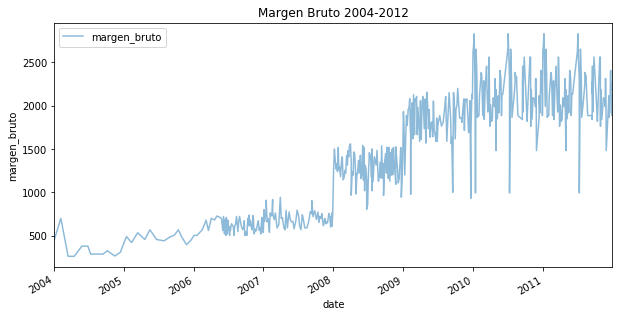

In [6]:
# gross margin 2004-2012
data.plot(kind='line', x='date', y='margen_bruto', alpha=0.5, figsize=(10,5), title='Margen Bruto 2004-2012')
plt.ylabel('margen_bruto')
plt.show()

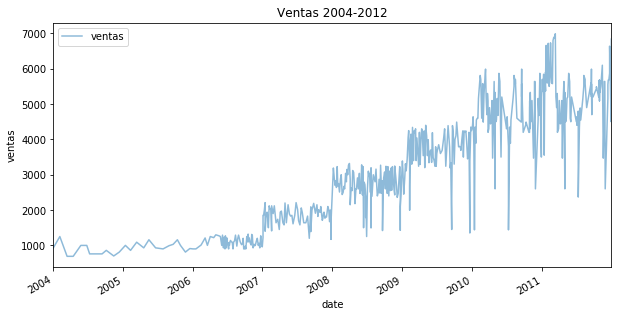

In [7]:
# sales 2004-2012
data.plot(kind='line', x='date', y='ventas', alpha=0.5, figsize=(10,5), title='Ventas 2004-2012')
plt.ylabel('ventas')
plt.show()

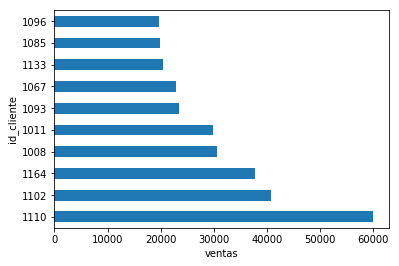

In [8]:
# top 10 costumers by gross margin
data.groupby('id_cliente')['margen_bruto'].sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.xlabel('ventas')
plt.show()

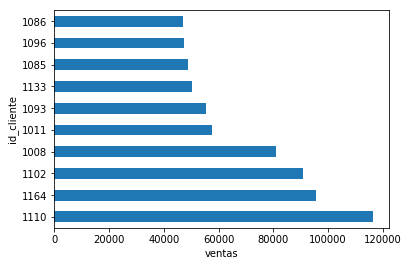

In [9]:
# top 10 costumers by sales
data.groupby('id_cliente')['ventas'].sum().sort_values(ascending=False)[:10].plot(kind='barh')
plt.xlabel('ventas')
plt.show()

In [10]:
# checking for correlation
corr_matrix = data.corr()
corr_matrix["ventas"].sort_values(ascending=False)

ventas            1.000000
lista_precio      0.972523
producto_id       0.956487
num_serie         0.947991
margen_bruto      0.927715
transaccion_id    0.914796
anho              0.913734
dia               0.046889
mes              -0.062257
id_cliente       -0.067456
vendedor_id      -0.091156
Name: ventas, dtype: float64

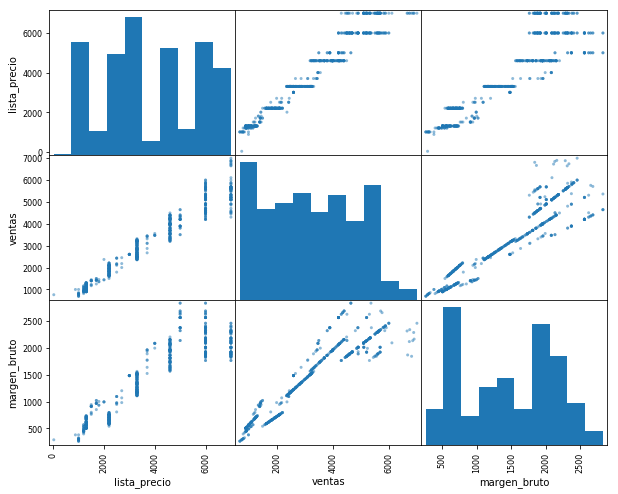

In [11]:
# checking for correlation
from pandas.plotting import scatter_matrix
attributes = ['lista_precio', 'ventas', 'margen_bruto']
scatter_matrix(data[attributes], figsize=(10, 8))
plt.show()

In [12]:
print('Number of unique transactions: ', data['transaccion_id'].nunique())
print('Number of unique customers: ', data['id_cliente'].nunique())
print('Number of unique products: ', data['producto_id'].nunique())
print('Number of unique serial number: ', data['num_serie'].nunique())
print('Number of unique vendors: ', data['vendedor_id'].nunique())

Number of unique transactions:  473
Number of unique customers:  157
Number of unique products:  5
Number of unique serial number:  653
Number of unique vendors:  37


### 3. RFM Model

**RFM** (Recency, Frequency, Monetary) Model is a behavior-based approach grouping customers into segments, using past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

- Recency (R): Who have purchased recently? Number of days since last purchase.
- Frequency (F): Who has purchased frequently? It means the total number of purchases.
- Monetary Value (M): Who have high purchase amount? It means the total money customer spent.

In [13]:
# first and last purchase
data['date'].min(),data['date'].max()

(Timestamp('2004-01-03 00:00:00'), Timestamp('2011-12-31 00:00:00'))

In [14]:
# date reference to calculate recency
now = dt.datetime(2012,1,1)
print(now)

2012-01-01 00:00:00


In [15]:
# calculating recency, frequency and monetary
rfm = data.groupby('id_cliente').agg({'date': lambda date:(now - date.max()).days,
                                     'transaccion_id': lambda num: len(num),
                                    'margen_bruto': lambda num: num.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()

,recency,frequency,monetary
id_cliente,,,
1001,823,1,1617
1002,1225,1,1128
1003,1692,1,774
1004,844,1,1563
1005,746,2,2800


The simplest way to create customers segments from RFM Model is to use **Quartiles**. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [16]:
# calculating quartiles
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['4', '3', '2', '1'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['1', '2', '3', '4'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['1', '2', '3', '4'])
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
id_cliente,,,,,,
1001,823,1,1617,3,1,1
1002,1225,1,1128,2,1,1
1003,1692,1,774,1,1,1
1004,844,1,1563,3,1,1
1005,746,2,2800,4,1,2


In [17]:
# creating rfm score
rfm['rfm_score'] = rfm['r_quartile'].astype(str)+ rfm['f_quartile'].astype(str) + rfm['m_quartile'].astype(str)
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score
id_cliente,,,,,,,
1001,823,1,1617,3,1,1,311
1002,1225,1,1128,2,1,1,211
1003,1692,1,774,1,1,1,111
1004,844,1,1563,3,1,1,311
1005,746,2,2800,4,1,2,412


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most

In [18]:
# best customers in terms of rfm score
rfm[rfm['rfm_score'] == '444'].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score
id_cliente,,,,,,,
1110,63,26,60047,4,4,4,444
1102,10,21,40826,4,4,4,444
1164,63,23,37819,4,4,4,444
1008,14,16,30688,4,4,4,444
1011,164,15,29799,4,4,4,444


In [19]:
print("Best Customers: ",len(rfm[rfm['rfm_score']=='444']))
print('Loyal Customers: ',len(rfm[rfm['f_quartile']=='4']))
print("Big Spenders: ",len(rfm[rfm['m_quartile']=='4']))
print('Almost Lost: ', len(rfm[rfm['rfm_score']=='244']))
print('Lost Best Customers: ',len(rfm[(rfm['rfm_score']=='144') | (rfm['rfm_score']=='143') | (rfm['rfm_score']=='134') | (rfm['rfm_score']=='133')]))
print('Lost Cheap Customers: ',len(rfm[rfm['rfm_score']=='111']))

Best Customers:  23
Loyal Customers:  34
Big Spenders:  39
Almost Lost:  2
Lost Best Customers:  5
Lost Cheap Customers:  20


### 4. Predictive Model

#### 4.1 Pre-Processing Data

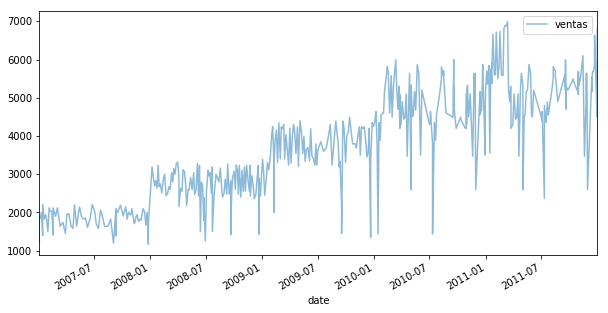

In [20]:
# we'll use data from 2007 to 2011
df = data[data['anho'] >= 2007]
df.plot(kind='line', x='date', y='ventas', alpha=0.5, figsize=(10,5))
plt.show()

In [21]:
features = ['anho', 'mes', 'dia', 'vendedor_id','producto_id','id_cliente', 'margen_bruto']

# define X and y
X = df[features].values
y = df['ventas'].values

In [22]:
# scale all numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X.astype(np.float))

In [23]:
# split dataframe into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 4.2. Predictive models

For this problem I will try 3 different models:

- Linear Regression
- Decision Tree
- Random Forest

Let's evaluate them:

In [24]:
seed=42

# define models
models = {'Linear Regression': LinearRegression(),
          'Decision Tree':DecisionTreeRegressor(random_state=seed),
          'Random Forest':RandomForestRegressor(n_jobs=-1, n_estimators=10, random_state=seed)}

y_pred = pd.DataFrame(columns=models.keys())
results = []

# train, predict and evaluate each model
for model in models.keys():  
    scores = cross_val_score(models[model], X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    rmse = np.sqrt(-scores)
    results.append({'Rmse': rmse.mean(),
                    'Model': str(model)})

In [25]:
models_results = pd.DataFrame(results)
models_results.sort_values('Rmse', inplace=True)
models_results = models_results.set_index('Model')
models_results

,Rmse
Model,
Random Forest,275.317447
Decision Tree,326.853326
Linear Regression,393.666875


**Random Forest** is the best model in terms of RMSE

#### 4.3. Tuning the model

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [200, 500, 1000], 'max_features': [2, 3, 4, 5, 6, 7]},
]

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=seed)
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [200, 500, 1000], 'max_features': [2, 3, 4, 5, 6, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [27]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 1000}

In [28]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [29]:
sorted(zip(feature_importances, features), reverse=True)

[(0.5415690325998875, 'margen_bruto'),
 (0.2917639698662191, 'producto_id'),
 (0.12619442395205335, 'anho'),
 (0.012528467605843344, 'mes'),
 (0.009941270093650874, 'dia'),
 (0.009460349657934207, 'id_cliente'),
 (0.008542486224411776, 'vendedor_id')]

In [30]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
print('final_rmse:', np.sqrt(final_mse))

final_rmse: 194.12548380470076


95% confidence interval for the test RMSE:

In [31]:
from scipy import stats

In [32]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([102.32869446, 254.75133997])

#### 4.4. Making predictions

In [33]:
dataTesting = pd.read_excel('test_data.xls')
clean_columns(dataTesting)
dataTesting.head()

,anho,mes,dia,vendedor_id,producto_id,id_cliente,margen_bruto,date
0,2012,1,1,2027,4000,1039,2623,2012-01-01
1,2012,1,4,2027,4000,1067,2684,2012-01-04
2,2012,1,7,2005,4000,1010,2830,2012-01-07
3,2012,1,11,2016,4000,1097,2318,2012-01-11
4,2012,1,14,2006,1000,1103,1993,2012-01-14


In [34]:
# scaling features
test = dataTesting.drop('date', axis=1).values
test = scaler.transform(test.astype(np.float))

In [35]:
dataTesting['ventas'] = final_model.predict(test)
dataTesting.head()

,anho,mes,dia,vendedor_id,producto_id,id_cliente,margen_bruto,date,ventas
0,2012,1,1,2027,4000,1039,2623,2012-01-01,5371.5451
1,2012,1,4,2027,4000,1067,2684,2012-01-04,5506.2871
2,2012,1,7,2005,4000,1010,2830,2012-01-07,5336.6014
3,2012,1,11,2016,4000,1097,2318,2012-01-11,5649.0550
4,2012,1,14,2006,1000,1103,1993,2012-01-14,3687.3020


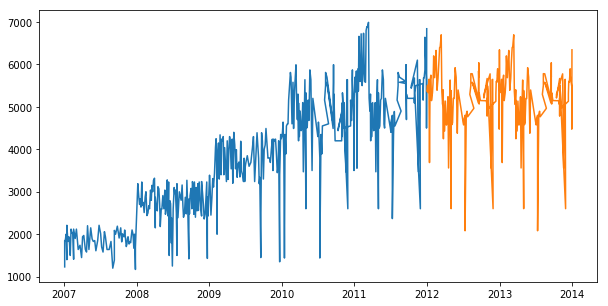

In [36]:
fig = plt.figure(figsize=(10,5))

for frame in [df, dataTesting]:
    plt.plot(frame['date'], frame['ventas'])
plt.show()

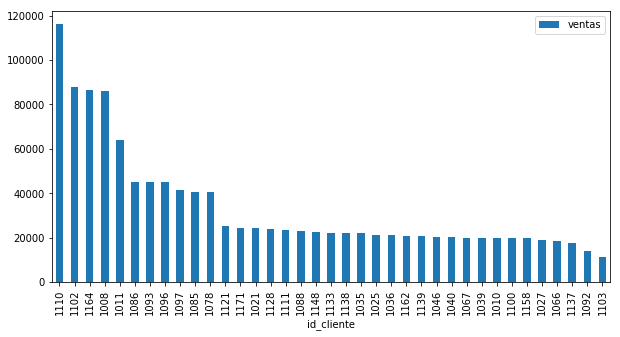

In [37]:
ventas = dataTesting.groupby('id_cliente').agg({'ventas':np.sum})
ventas.sort_values('ventas', ascending=False).plot(kind='bar', sort_columns=True, figsize=(10,5))
plt.show()

In [38]:
# top 10 customers during the next two years, representing 53% of total sales
ventas_pct = dataTesting.groupby('id_cliente').agg({'ventas':np.sum}).apply(lambda x:((x / x.sum())*100).round(1))
ventas_pct.sort_values('ventas', ascending=False).head(10)

,ventas
id_cliente,
1110,9.4
1102,7.1
1008,7.0
1164,7.0
1011,5.2
1086,3.6
1096,3.6
1093,3.6
1078,3.3


In [39]:
ventas_pct.sort_values('ventas', ascending=False).head(10).sum()

ventas    53.1
dtype: float64